# Logistic, Decision Tree, Random Forest and Gradient Boosting Classifiers

<p>The following notebook provides an example code of predicting whether the student will have  <b> high</b> or <b> low</b> Final Grade using 4 different Classification Models. 
The dependent variable is <b>Final_Grade </b>, which is initially continuous variable but will be transformed to binary <b>(1-"High grade", 0-"Low Grade")</b>. 

<br>The general sequence of steps for the analysis the following:
1. [Descriptive analysis](#pandas)
2. [Linear, Decision Tree, Random Forest and Gradient Boosting Classification Models on Not transformed data](#stats)
3. [Linear, Decision Tree, Random Forest and Gradient Boosting Classification Models on reduced data](#stats1)
4. [Predicting for a new observation](#obs)
5. [Conclusion](#stats2)

 <h2>1.Descriptive analysis</h2> <a name="pandas"></a>

The initial data consists of 395 observations of 32 variables. There are no duplicates, missing values and variables with single value for all observations.
We will first implement all 4 models on raw, unchanged data, observe the results and then perform the same analysis on transformed data.
Our dependent variable is Final_Grade, which is numeric variable having values in [0;20] range. To be able to transform it into categorical, we examined variable distribution and found out that it is more or less equally spread around mean (10.4). Taking into account that median (11) is not too much far from the mean, we have decided to split the data based on the mean (rounded down, to 10, as there are only integers).
After target transformation into binary, we can see that the category distribution is relatively balanced (1's are 53% and 0s are 47% of the data).

**Note!** 
        1. We choose a common metric to compare model performance based on the data and analysis scope.
        2. Winning model selection is done based on mean cross-validation score.


In [1]:
#data manipulation and visualization libraries
#for not showing warnings
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#libraries for modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

In [2]:
#importing the data and making a dataframe
data=pd.read_excel("Student_data.xlsx")

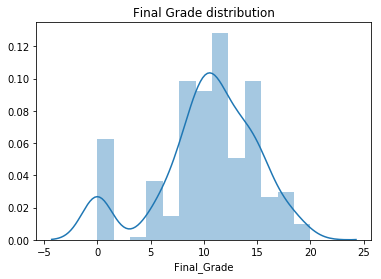

In [3]:
sns.distplot(data.Final_Grade)
plt.title("Final Grade distribution")
plt.show()

In [4]:
data.Final_Grade.describe()

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: Final_Grade, dtype: float64

In [5]:
print("Final Grade median:",data.Final_Grade.median())
print("Final Grade mean:",data.Final_Grade.mean())

Final Grade median: 11.0
Final Grade mean: 10.415189873417722


In [6]:
#transforming data :1-high grade and 0-low grade
data.Final_Grade=np.where(data.Final_Grade>10,1,0)

In [7]:
#have a look at first rows of the dataframe
data.head()

,StudentID,school2,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,Final_Grade
0,1,GP,F,18,U,GT3,A,4,4,at_home,...,no,no,4,3,4,1,1,3,6,0
1,2,GP,F,17,U,GT3,T,1,1,at_home,...,yes,no,5,3,3,1,1,3,4,0
2,3,GP,F,15,U,LE3,T,1,1,at_home,...,yes,no,4,3,2,2,3,3,10,0
3,4,GP,F,15,U,GT3,T,4,2,health,...,yes,yes,3,2,2,1,1,5,2,1
4,5,GP,F,16,U,GT3,T,3,3,other,...,no,no,4,3,2,1,2,5,4,0


In [8]:
data.describe()

,StudentID,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,Final_Grade
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,198.000000,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,0.529114
std,114.170924,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,0.499785
min,1.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,99.500000,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000
50%,198.000000,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,1.000000
75%,296.500000,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,1.000000
max,395.000000,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,1.000000


In [9]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


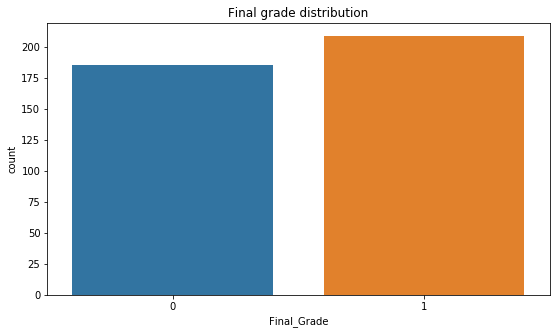

In [10]:
#let's visualise the distribution of y
plt.figure(figsize=(9,5))
sns.countplot(data.Final_Grade)
plt.title("Final grade distribution")
plt.show()

In [11]:
#lets count the benchmark for deposit subscription distribution
#we have balanced data
data.Final_Grade.value_counts(normalize=True).mul(100).rename("Final grade distribution")

1    52.911392
0    47.088608
Name: Final grade distribution, dtype: float64

In [12]:
#Model building
data_dum=pd.get_dummies(data,drop_first=True)

In [13]:
Y=data_dum["Final_Grade"]
X=data_dum.drop("Final_Grade", axis=1)

In [14]:
#splitting the data into train and test sets, as have small data will use 15% for the testing set
X0, X1, Y0, Y1= train_test_split(X, Y, test_size=0.15, random_state=42)

<h2>Linear, Decision Tree, Random Forest and Gradient Boosting Classification Models on Not transformed data</h2> <a name="stats"></a>

We are concerned to predict correctly both high and low final grades, so we will use `"roc_auc"` for scoring purposes, to ensure maximizing correct predictions for both of them. `"roc_auc"`score will also be our metric for choosing the winning model.
The steps of model building using sklearn are the following:

           1.Set parameter ranges based on model and Use GridSearchCV to find best parameters.Fit GridSearch on training set
           2.Build(fit) the model on training set and calculate the needed score (in our case-"roc_auc") for training and 
              testing sets.
              Note that we calculate `roc_auc`score based on probabilities!(use `predict_proba()`)*
           3.Calculate the outlined metric (in our case-`roc_auc`) using `cross_val_score()`on the whole data (X and Y),
              to be able to see the overall model performance.
           4. Based on the results and best parameters, go back and adjust (tune) parameter ranges to get better scores on 
              train-test sets and for cross-validation score

In [15]:
#setting Logistic regression parameters range
param_logit={'class_weight':[None,'balanced'],
            'C':np.linspace(0.001,5,100)}

In [16]:
#gridsearching to find best params
#verbose is for showing this sentence-"Fitting 3 folds for each of 200 candidates, totalling 600 fits"
gridsearch_logit = GridSearchCV(estimator=LogisticRegression(random_state=42),
                        param_grid=param_logit,
                        cv=3,scoring='roc_auc',verbose=1,n_jobs=2)
gridsearch_logit.fit(X0,Y0)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:    6.0s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'class_weight': [None, 'balanced'], 'C': array([1.00000e-03, 5.14949e-02, ..., 4.94951e+00, 5.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [17]:
#best params for logit
gridsearch_logit.best_params_

{'C': 0.10198989898989898, 'class_weight': 'balanced'}

In [18]:
#let's construct logit with the best parameters 
logit=LogisticRegression(class_weight=None,C=0.10198989898989898,random_state=42).fit(X0,Y0)

In [19]:
#getting probabilities of being 1 (probability of having high final grade)
Y0_logit=logit.predict_proba(X0)[:,1]
Y1_logit=logit.predict_proba(X1)[:,1]

In [20]:
#calculating roc auc score
print("ROC_AUC Train not scaled Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test not scaled Logit:",roc_auc_score(Y1,Y1_logit).round(2))
print("Mean 3-fold ROC AUC score for not scaled logit:",np.mean(cross_val_score(estimator=logit, X=X,y=Y,cv=3, scoring="roc_auc").round(2)))

ROC_AUC Train not scaled Logit: 0.79
ROC_AUC Test not scaled Logit: 0.73
Mean 3-fold ROC AUC score for not scaled logit: 0.6733333333333333


In [21]:
#Lets also scale and see whether the results will change
sc=StandardScaler()
numerics=data.select_dtypes(exclude="object").drop("Final_Grade", axis=1) #outlining only continuous variables for scaling
                                                                         #and dropping Final_Grade as it is already 0 and 1  
numerics=pd.DataFrame(sc.fit_transform(numerics), columns=numerics.columns.tolist())#making DF out of scaled numeric variables

C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [22]:
#contatenating with the rest of the data 
data_sc=pd.concat([numerics,data.drop(numerics.columns.tolist(), axis=1)],axis=1)

In [23]:
#now we have scaled data of the same shape
data_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 32 columns):
StudentID      395 non-null float64
age            395 non-null float64
Medu           395 non-null float64
Fedu           395 non-null float64
traveltime     395 non-null float64
studytime      395 non-null float64
failures       395 non-null float64
famrel         395 non-null float64
freetime       395 non-null float64
goout          395 non-null float64
Dalc           395 non-null float64
Walc           395 non-null float64
health         395 non-null float64
absences       395 non-null float64
school2        395 non-null object
sex            395 non-null object
address        395 non-null object
famsize        395 non-null object
Pstatus        395 non-null object
Mjob           395 non-null object
Fjob           395 non-null object
reason         395 non-null object
guardian       395 non-null object
schoolsup      395 non-null object
famsup         395 non-null object
paid  

In [24]:
#getting dummies on scaled data
data_sc=pd.get_dummies(data_sc, drop_first=True)

In [25]:
#separating X and Y, 
#!!!Y is not scaled, just writing Y_sc to keep variable names consistent with the data
Y_sc=data_sc["Final_Grade"]
X_sc=data_sc.drop("Final_Grade", axis=1)

In [26]:
#train test split
X0_sc, X1_sc, Y0_sc, Y1_sc=train_test_split(X_sc,Y_sc,test_size=0.15, random_state=42)

In [27]:
#GridSearching Logit on scaled data
gs_logit_scaled=GridSearchCV(estimator=LogisticRegression(random_state=42),param_grid=param_logit,
                        scoring="roc_auc",
                        cv=3,verbose=1).fit(X0_sc,Y0_sc)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.1s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [28]:
gs_logit_scaled.best_params_

{'C': 0.001, 'class_weight': None}

In [29]:
logit_scaled=LogisticRegression(C=0.001, class_weight=None, random_state=42).fit(X0_sc,Y0_sc)

In [30]:
#getting probabilities for scaled data
Y0_logit_sc=logit_scaled.predict_proba(X0_sc)[:,1]
Y1_logit_sc=logit_scaled.predict_proba(X1_sc)[:,1]

In [31]:
#calculating roc auc score and mean CV score: note that I haven't separately saved predicted probabilities
print("ROC_AUC Train for Scaled logit:",roc_auc_score(Y0,Y0_logit_sc).round(2))
print("ROC_AUC Test for Scaled logit:",roc_auc_score(Y1,Y1_logit_sc).round(2))
print("Mean 3-fold ROC AUC score for Scaled logit:",np.mean(cross_val_score(estimator=logit_scaled, X=X_sc,y=Y_sc,cv=3, scoring="roc_auc").round(2)))

ROC_AUC Train for Scaled logit: 0.71
ROC_AUC Test for Scaled logit: 0.7
Mean 3-fold ROC AUC score for Scaled logit: 0.6733333333333333


<h3>Decision Tree Classifier</h3>

In [32]:
#setting up the ranges for hyperparameters
param_dt={"max_depth":range(1,10),"min_samples_leaf":range(4,84,5),
          "class_weight":["balanced", None],}

In [33]:
#Cross-Validated Gridsearch using parameters, use n_jobs=-1 for faster computing and 
gs_dt=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_grid=param_dt,scoring="roc_auc",cv=3, verbose=1)
gs_dt.fit(X0,Y0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:    4.2s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 10), 'min_samples_leaf': range(4, 84, 5), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [34]:
#let's see the optimal parameters
gs_dt.best_params_

{'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 34}

In [35]:
#fitting the model with best parameters
dt_grid=DecisionTreeClassifier(class_weight="balanced",max_depth=4,
                             min_samples_leaf=34, random_state=42).fit(X0,Y0)

#getting probabilities
Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]

In [36]:
#calculating roc auc score 
print("ROC_AUC Train for Decision Tree:",roc_auc_score(Y0,Y0_dt_grid).round(2))
print("ROC_AUC Test for Decision Tree:",roc_auc_score(Y1,Y1_dt_grid).round(2))
print("Mean 3-fold ROC AUC score for Decision Tree:",np.mean(cross_val_score(estimator=dt_grid, X=X,y=Y,cv=3, scoring="roc_auc")).round(2))

ROC_AUC Train for Decision Tree: 0.72
ROC_AUC Test for Decision Tree: 0.71
Mean 3-fold ROC AUC score for Decision Tree: 0.64


<h3>Random Forest Classifier</h3>

In [37]:
#setting rf param grid
param_rf={  'max_depth': range(1,6),
            'min_samples_leaf': range(4, 44, 5),
             'class_weight': ['balanced', None] }

In [38]:
#Random Forest Regression, using initial same parameters as for dt
#Cross-Validated Gridsearch using parameters, use n_jobs=-1 for faster computing
gs_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_grid=param_rf,cv=3, scoring="roc_auc", verbose=1)
gs_rf.fit(X0,Y0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    2.9s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 6), 'min_samples_leaf': range(4, 44, 5), 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [39]:
gs_rf.best_params_

{'class_weight': None, 'max_depth': 2, 'min_samples_leaf': 4}

In [40]:
#fitting the model with best parameters
rf=RandomForestClassifier(random_state=42,class_weight=None,max_depth=2,min_samples_leaf=4).fit(X0,Y0)

#getting probabilities
Y0_rf=rf.predict_proba(X0)[:,1]
Y1_rf=rf.predict_proba(X1)[:,1]

In [41]:
#calculating roc auc score 
print("ROC_AUC Train for Random Forest:",roc_auc_score(Y0,Y0_rf).round(2))
print("ROC_AUC Test for Random Forest:",roc_auc_score(Y1,Y1_rf).round(2))
#Mean cross val score for model with default hyperparameters
print("Mean 3-fold ROC AUC score for Random Forest:",np.mean(cross_val_score(estimator=rf, X=X,y=Y,cv=3, scoring="roc_auc",)).round(2))

ROC_AUC Train for Random Forest: 0.73
ROC_AUC Test for Random Forest: 0.65
Mean 3-fold ROC AUC score for Random Forest: 0.62


<h3>Gradient Boosting Classifier</h3>

In [42]:
#gradient boosting doesn't have "class_weight" parameter, so setting new parameters dictionary
param_gb={'max_depth': range(5, 21),
          'min_samples_leaf': range(80, 125, 5)}

In [43]:
#Random Forest Regression
#Cross-Validated Gridsearch using parameters, use n_jobs=-1 for faster computing and 
gs_gb=GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),param_grid=param_gb,cv=3, scoring="roc_auc", verbose=1)
gs_gb.fit(X0,Y0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:   13.1s finished
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(5, 21), 'min_samples_leaf': range(80, 125, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [44]:
gs_gb.best_params_

{'max_depth': 5, 'min_samples_leaf': 90}

In [45]:
#fitting the model with best parameters
gb=GradientBoostingClassifier(random_state=42,max_depth=5,min_samples_leaf=90).fit(X0,Y0)
#getting probabilities
Y0_gb=gb.predict_proba(X0)[:,1]
Y1_gb=gb.predict_proba(X1)[:,1]

In [46]:
#calculating roc auc score 
print("ROC_AUC Train for Tuned Gradient Boosting:",roc_auc_score(Y0,Y0_gb).round(2))
print("ROC_AUC Test for Tuned Gradinet Boosting:",roc_auc_score(Y1,Y1_gb).round(2))
#Mean cross val score for model with default hyperparameters
print("Mean 3-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters:",np.mean(cross_val_score(estimator=gb, X=X,y=Y,cv=3, scoring="roc_auc",)).round(2))

ROC_AUC Train for Tuned Gradient Boosting: 0.79
ROC_AUC Test for Tuned Gradinet Boosting: 0.65
Mean 3-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters: 0.58


In [47]:
print("Mean 3-fold ROC AUC score for not scaled LOGIT:",np.mean(cross_val_score(estimator=logit, X=X,y=Y,cv=3, scoring="roc_auc").round(2)))
print("Mean 3-fold ROC AUC score for Scaled LOGIT:",np.mean(cross_val_score(estimator=logit_scaled, X=X_sc,y=Y_sc,cv=3, scoring="roc_auc").round(2)))
print("Mean 3-fold ROC AUC score for DT Tuned hyperparameters:",np.mean(cross_val_score(estimator=dt_grid, X=X,y=Y,cv=3, scoring="roc_auc")).round(2))
print("Mean 3-fold ROC AUC score for Random Forest Tuned hyperparameters:",np.mean(cross_val_score(estimator=rf, X=X,y=Y,cv=3, scoring="roc_auc",)).round(2))
print("Mean 3-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters:",np.mean(cross_val_score(estimator=gb, X=X,y=Y,cv=3, scoring="roc_auc",)).round(2))

Mean 3-fold ROC AUC score for not scaled LOGIT: 0.6733333333333333
Mean 3-fold ROC AUC score for Scaled LOGIT: 0.6733333333333333
Mean 3-fold ROC AUC score for DT Tuned hyperparameters: 0.64
Mean 3-fold ROC AUC score for Random Forest Tuned hyperparameters: 0.62
Mean 3-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters: 0.58


<h3>Linear, Decision Tree, Random Forest and Gradient Boosting Classification Models on reduced data </h3> <a name="stats2"></a>

I saved the data obtained from backward elimination into csv and will use it to reveal how the scorings change based on the quality of data. For backward elimination see https://nbviewer.jupyter.org/github/srbuhimirzoyan/Business_Analytics_Fall2019/blob/master/Session4/Session_4_Final..ipynb#select
For the sake of simplicity and time saving, we will use the same best parameters we got for non-transformed data, to calculate the mean cross-val-score results. In other words, we will not perform new grid searches for every model, but will use already given best parameters for each model.**Note!** To have much better results, you should perform every step for the backward eliminated data as we did above.
In any case, we can see that for reduced dataset and even without performing new grid searches, we have much higher results for 
mean 3-fold CV scores of all models, except gradient boosting.


In [48]:
#reading backward eliminated data
data_tr=pd.read_csv("backward_students.csv")

In [49]:
#making Final grade categorical
data_tr.Final_Grade=np.where(data_tr.Final_Grade>10,1,0)

In [50]:
#making dummies
data_tr_dum=pd.get_dummies(data_tr, drop_first=True)

In [51]:
#separating X and Y
Y_tr=data_tr_dum["Final_Grade"]
X_tr=data_tr_dum.drop("Final_Grade", axis=1)

In [52]:
#train-test split
X0_tr,X1_tr,Y0_tr,Y1_tr=train_test_split(X_tr,Y_tr, test_size=0.15, random_state=42)

In [53]:
#scaled data
numerics_tr=data_tr.select_dtypes(exclude="object").drop("Final_Grade", axis=1) #outlining only continuous variables for scaling
                                                                         #and dropping Final_Grade as it is already 0 and 1  
numerics_tr=pd.DataFrame(sc.fit_transform(numerics_tr), columns=numerics_tr.columns.tolist())#making DF out of scaled numeric variables
#contatenating with the rest of the data 
data_tr_scaled=pd.concat([numerics_tr,data_tr.drop(numerics_tr.columns.tolist(), axis=1)],axis=1)
X_tr_sc=data_tr_scaled.drop("Final_Grade", axis=1)
Y_tr_sc=data_tr_scaled["Final_Grade"]
X0_tr_sc,X1_tr_sc,Y0_tr_sc,Y1_tr_sc=train_test_split(X_tr_sc,Y_tr_sc, test_size=0.15, random_state=42)

C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Srbuhi\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [55]:
#outlining models with already got best params for not reduced data
logit_tr=LogisticRegression(C=0.10198989898989898,class_weight=None, random_state=42).fit(X0_tr,Y0_tr)
logit_tr_scaled=LogisticRegression(C=0.001, class_weight=None, random_state=42).fit(X0_tr_sc,Y0_tr_sc)
dt_grid_tr=DecisionTreeClassifier(class_weight='balanced',max_depth=4,min_samples_leaf=34,random_state=42).fit(X0_tr,Y0_tr)
rf_tr=RandomForestClassifier(class_weight=None, max_depth=2, min_samples_leaf=4, random_state=42).fit(X0_tr,Y0_tr)
gb_tr=GradientBoostingClassifier(max_depth=5,min_samples_leaf=90,random_state=42).fit(X0_tr,Y0_tr)

In [56]:
#summary of scores
print("Mean 3-fold ROC AUC score for not scaled LOGIT on reduced data:",np.mean(cross_val_score(estimator=logit_tr, X=X_tr,y=Y_tr,cv=3, scoring="roc_auc").round(2)))
print("Mean 3-fold ROC AUC score for Scaled LOGIT on reduced data:",np.mean(cross_val_score(estimator=logit_tr_scaled, X=X_tr_sc,y=Y_tr_sc,cv=3, scoring="roc_auc").round(2)))
print("Mean 3-fold ROC AUC score for DT Tuned hyperparameters on reduced data:",np.mean(cross_val_score(estimator=dt_grid_tr, X=X_tr,y=Y_tr,cv=3, scoring="roc_auc")).round(2))
print("Mean 3-fold ROC AUC score for Random Forest Tuned hyperparameters on reduced data:",np.mean(cross_val_score(estimator=rf_tr, X=X_tr,y=Y_tr,cv=3, scoring="roc_auc",)).round(2))
print("Mean 3-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters on reduced data:",np.mean(cross_val_score(estimator=gb_tr, X=X_tr,y=Y_tr,cv=3, scoring="roc_auc",)).round(2))

Mean 3-fold ROC AUC score for not scaled LOGIT on reduced data: 0.7166666666666667
Mean 3-fold ROC AUC score for Scaled LOGIT on reduced data: 0.7133333333333334
Mean 3-fold ROC AUC score for DT Tuned hyperparameters on reduced data: 0.67
Mean 3-fold ROC AUC score for Random Forest Tuned hyperparameters on reduced data: 0.67
Mean 3-fold ROC AUC score for Gradinet Boosting Tuned hyperparameters on reduced data: 0.56


<h3>Predicting for a new observation </h3> <a name="obs"></a>

For example of prediction on a new observation, we will use reduced dataset.
We want to predict Y, based on X. Thus, we have to provide values for our X.
Let's see what our X test looks like, what columns it has, to provide similar ones to new observation.

In [57]:
X_tr.describe()

,Medu,failures,goout,absences,Mjob_health,Mjob_services,schoolsup_yes,famsup_yes,romantic_yes
count,395.000000,395.000000,395.000000,3.950000e+02,395.000000,395.000000,395.000000,395.000000,395.000000
mean,2.749367,0.334177,3.108861,3.199874e-01,0.086076,0.260759,0.129114,0.612658,0.334177
std,1.094735,0.743651,1.113278,4.397442e-01,0.280832,0.439606,0.335751,0.487761,0.472300
min,0.000000,0.000000,1.000000,2.678637e-33,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,3.354626e-04,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,0.000000,3.000000,1.831564e-02,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.000000,0.000000,4.000000,1.000000e+00,0.000000,1.000000,0.000000,1.000000,1.000000
max,4.000000,3.000000,5.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
#Based on the above data, let's define a new observation, aram, with the following values for respective columns
aram=[[2,4,1,2,0,1,0,1,1]]

In [59]:
#let's predict aram's final grade class using .predict()
print("Aram's grade based on Logit:",logit_tr.predict(aram))
print("Aram's grade based on DT:",dt_grid_tr.predict(aram))
print("Aram's grade based on RF:",rf_tr.predict(aram))
print("Aram's grade based on GB:",gb_tr.predict(aram))

Aram's grade based on Logit: [0]
Aram's grade based on DT: [0]
Aram's grade based on RF: [0]
Aram's grade based on GB: [1]


Based on all Logit, DT and GB: Aram's grade belong to class 1 ("high"). According to Gradient Boosting, it will be class 0("low")

<h3>Conclusion</h3> <a name="stats2"></a>

We performed 2 rounds of classification models: the first on not-transformed data, the second on data reduced via backward elimination.
For the first round, we performed ***Logit, DT, RF, GB*** and ***Logit on scaled data***.
For the second round, we performed same steps but for data reduced via backward elimination.
According to results, models perform better when data does not contain redundant, not significant variables.
Based on both rounds, according to mean 3-fold cross-validation score, the winning model is Logistic Regression on not scaled reduced dataset with 0.716 `roc_auc` score. The worst one is <u>gradient boosting.</u>
We clearly saw that all tree-based models overfitted and one of the reasons may be small data, presence of a  lot of unnecessary variables.